## This is part 3 of my pyspark project series:
We are going to be focussing on Demographic Insights

Demographic insights, which would involve analyzing demographic data like age, education level, and years of experience.

Objectives for Part 3: Demographic Insights

Age Distribution and Country Analysis:

Analyze the age distribution of the respondents to understand the generational composition of the tech workforce.
*   Explore the relationship between respondents' ages and their countries.
*   Visualize the age distribution to highlight the predominant age groups and show how age distribution varies across different countries
        focusing on the top 10 countries to avoid clutter.

Educational Background:
*   Examine the highest level of education attained by the respondents.
*   Identify trends in educational qualifications within the tech industry.
*   Visualize the distribution of education levels to provide a clear understanding of the industry's educational landscape.
        
Years of Professional Coding Experience:
*   Assess the distribution of professional coding experience among the respondents
*   Understand the career stages of tech professionals, from early to late career.
*   Visualize the data to highlight the predominant experience ranges and provide insights into career development trends.

In [33]:
 # import necessary libraries for this project

from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.sql.functions import col, when, avg
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [34]:
# Initialize Spark session with local file system configuration
spark = SparkSession.builder \
    .appName("CSV to DataFrame") \
    .config("spark.hadoop.fs.defaultFS", "file:///") \
    .getOrCreate()

# This config is to ensure output can be readable and not overlapping
spark.conf.set("spark.sql.debug.maxToStringFields", "100") 
 
# Define the path to the CSV file
csv_path = "survey_results_public.csv"
# Read the CSV file into a DataFrame
df = spark.read.csv(csv_path, header=True, inferSchema=True)

# Count the number of rows and columns
num_rows = df.count()
num_columns = len(df.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

#output : Number of rows: 89184 / Number of columns: 84

Number of rows: 89184
Number of columns: 84


In [35]:
df.show(3)

+----------+-------+--------------------+---------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+---------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+----------------------------+----------------------------+--------------------+---------------------+------------------------------+------------------------------+-----------------------------+-----------------------------+----------------------+----------------------+-------------------+-------------------+--------------------+-----------------

In [36]:
columns_needed = ['Age', 'EdLevel','YearsCode', 'YearsCodePro', 'Country']

df_demo = df.select(*columns_needed)

In [37]:
df_demo.show(5)


+---------------+--------------------+---------+------------+--------------------+
|            Age|             EdLevel|YearsCode|YearsCodePro|             Country|
+---------------+--------------------+---------+------------+--------------------+
|18-24 years old|                  NA|       NA|          NA|                  NA|
|25-34 years old|Bachelor’s degree...|       18|           9|United States of ...|
|45-54 years old|Bachelor’s degree...|       27|          23|United States of ...|
|25-34 years old|Bachelor’s degree...|       12|           7|United States of ...|
|25-34 years old|Bachelor’s degree...|        6|           4|         Philippines|
+---------------+--------------------+---------+------------+--------------------+
only showing top 5 rows



In [38]:
#printing the schma for the df_demo dataframe. would need to convert types for YearsCode, YearsCodePro
df_demo.printSchema()

root
 |-- Age: string (nullable = true)
 |-- EdLevel: string (nullable = true)
 |-- YearsCode: string (nullable = true)
 |-- YearsCodePro: string (nullable = true)
 |-- Country: string (nullable = true)



In [85]:
df1 = df_demo.select('Age').distinct().collect()
df1

[Row(Age='45-54 years old'),
 Row(Age='Prefer not to say'),
 Row(Age='18-24 years old'),
 Row(Age='65 years or older'),
 Row(Age='25-34 years old'),
 Row(Age='Under 18 years old'),
 Row(Age='55-64 years old'),
 Row(Age='35-44 years old')]

In [48]:
def count_na_values(df, columns):
    na_counts = {}
    for column in columns:
        na_count = df.filter(col(column) == 'NA').count()
        na_counts[column] = na_count
    return na_counts

In [49]:
string_columns = ['Age', 'EdLevel', 'YearsCode', 'YearsCodePro', 'Country']
na_counts = count_na_values(df_demo, string_columns)
print(na_counts)

{'Age': 0, 'EdLevel': 1211, 'YearsCode': 1749, 'YearsCodePro': 23048, 'Country': 1211}


In [50]:
from pyspark.sql import DataFrame
from pyspark.sql import functions as F

def convert_na_to_null(df: DataFrame, columns: list) -> DataFrame:
    for column in columns:
        df = df.withColumn(column, F.when(F.col(column) == 'NA', F.lit(None)).otherwise(F.col(column)))
    return df


In [51]:
df_demo = convert_na_to_null(df_demo, string_columns)

In [54]:
df_demo.show(5)
na_counts = count_na_values(df_demo, string_columns)
print(na_counts)

+---------------+--------------------+---------+------------+--------------------+
|            Age|             EdLevel|YearsCode|YearsCodePro|             Country|
+---------------+--------------------+---------+------------+--------------------+
|18-24 years old|                NULL|     NULL|        NULL|                NULL|
|25-34 years old|Bachelor’s degree...|       18|           9|United States of ...|
|45-54 years old|Bachelor’s degree...|       27|          23|United States of ...|
|25-34 years old|Bachelor’s degree...|       12|           7|United States of ...|
|25-34 years old|Bachelor’s degree...|        6|           4|         Philippines|
+---------------+--------------------+---------+------------+--------------------+
only showing top 5 rows



{'Age': 0, 'EdLevel': 0, 'YearsCode': 0, 'YearsCodePro': 0, 'Country': 0}


In [56]:
def transform_years_code(df: DataFrame, columns: list) -> DataFrame:
    for col in columns:
        df = df.withColumn(
            col,
            F.when(F.col(col) == 'Less than 1 year', 0)
                .when(F.col(col) == 'More than 50 years', 51)
                .otherwise(F.col(col))
        ).withColumn(col, F.col(col).cast('integer'))
    return df

# Columns to transform
columns_to_transform = ['YearsCode', 'YearsCodePro']

# Apply the transformation function to df_comp_cleaned
df_demo_transformed = transform_years_code(df_demo, columns_to_transform)

# Print the schema to verify changes
df_demo_transformed.printSchema()

# Show the transformed DataFrame
df_demo_transformed.show(5)


root
 |-- Age: string (nullable = true)
 |-- EdLevel: string (nullable = true)
 |-- YearsCode: integer (nullable = true)
 |-- YearsCodePro: integer (nullable = true)
 |-- Country: string (nullable = true)

+---------------+--------------------+---------+------------+--------------------+
|            Age|             EdLevel|YearsCode|YearsCodePro|             Country|
+---------------+--------------------+---------+------------+--------------------+
|18-24 years old|                NULL|     NULL|        NULL|                NULL|
|25-34 years old|Bachelor’s degree...|       18|           9|United States of ...|
|45-54 years old|Bachelor’s degree...|       27|          23|United States of ...|
|25-34 years old|Bachelor’s degree...|       12|           7|United States of ...|
|25-34 years old|Bachelor’s degree...|        6|           4|         Philippines|
+---------------+--------------------+---------+------------+--------------------+
only showing top 5 rows



In [57]:
df_demo_transformed.groupBy('Age').count().show()

+------------------+-----+
|               Age|count|
+------------------+-----+
|   45-54 years old| 8334|
| Prefer not to say|  449|
|   18-24 years old|17931|
| 65 years or older| 1171|
|   25-34 years old|33247|
|Under 18 years old| 4128|
|   55-64 years old| 3392|
|   35-44 years old|20532|
+------------------+-----+



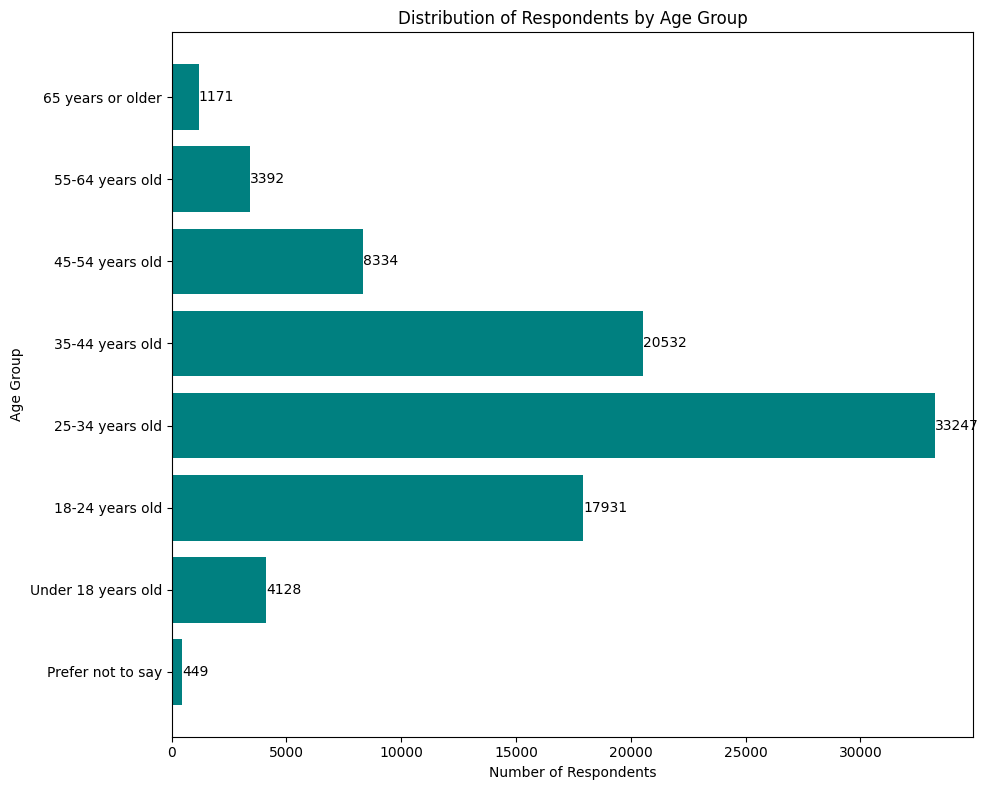

In [64]:
# Define the custom order
age_order = [
    'Prefer not to say',
    'Under 18 years old',
    '18-24 years old',
    '25-34 years old',
    '35-44 years old',
    '45-54 years old',
    '55-64 years old',
    '65 years or older'
]

# Collect Spark DataFrame to Pandas DataFrame
df_age_pandas = df_demo_transformed.groupBy('Age').count().toPandas()

# Ensure 'Age' column is a categorical type with the defined order
df_age_pandas['Age'] = pd.Categorical(df_age_pandas['Age'], categories=age_order, ordered=True)

# Sort by the custom order
df_age_pandas = df_age_pandas.sort_values('Age')

# Plotting
plt.figure(figsize=(10, 8))
bars = plt.barh(df_age_pandas['Age'], df_age_pandas['count'], color='teal')

# Adding the number of users to the end of the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, int(bar.get_width()), va='center')

plt.xlabel('Number of Respondents')
plt.ylabel('Age Group')
plt.title('Distribution of Respondents by Age Group')
plt.tight_layout()
plt.show()


In [79]:
# Group by 'Country' and 'Age' and count the number of respondents
df_age_country_counts = df_demo_transformed.groupBy('Country', 'Age').count()

# Convert to Pandas DataFrame
df_age_country_pandas = df_age_country_counts.toPandas()


In [82]:
# Calculate total respondents per country
df_country_totals = df_age_country_pandas.groupby('Country').sum().reset_index()

# Sort and select the top 10 countries by user count
top_10_countries = df_country_totals.sort_values(by='count', ascending=False).head(10)['Country']

# Filter the original DataFrame to include only these top 10 countries
df_top_10_countries = df_age_country_pandas[df_age_country_pandas['Country'].isin(top_10_countries)]
# Pivot the DataFrame
df_pivot_top_10 = df_top_10_countries.pivot(index='Country', columns='Age', values='count').fillna(0)


In [86]:
df_pivot_top_10

Age,18-24 years old,25-34 years old,35-44 years old,45-54 years old,55-64 years old,65 years or older,Prefer not to say,Under 18 years old
Country,,,,,,,,
Australia,305,574,563,304,125,68,15,124
Brazil,415,881,478,175,28,11,1,53
Canada,522,1257,907,396,171,55,14,185
France,588,1214,694,246,75,30,5,81
Germany,1449,2768,1808,615,295,52,11,330
India,2296,2289,512,107,20,4,19,378
Netherlands,487,884,543,232,121,41,4,71
Poland,548,1024,582,104,12,7,8,150
United Kingdom of Great Britain and Northern Ireland,824,1832,1360,750,335,137,25,289


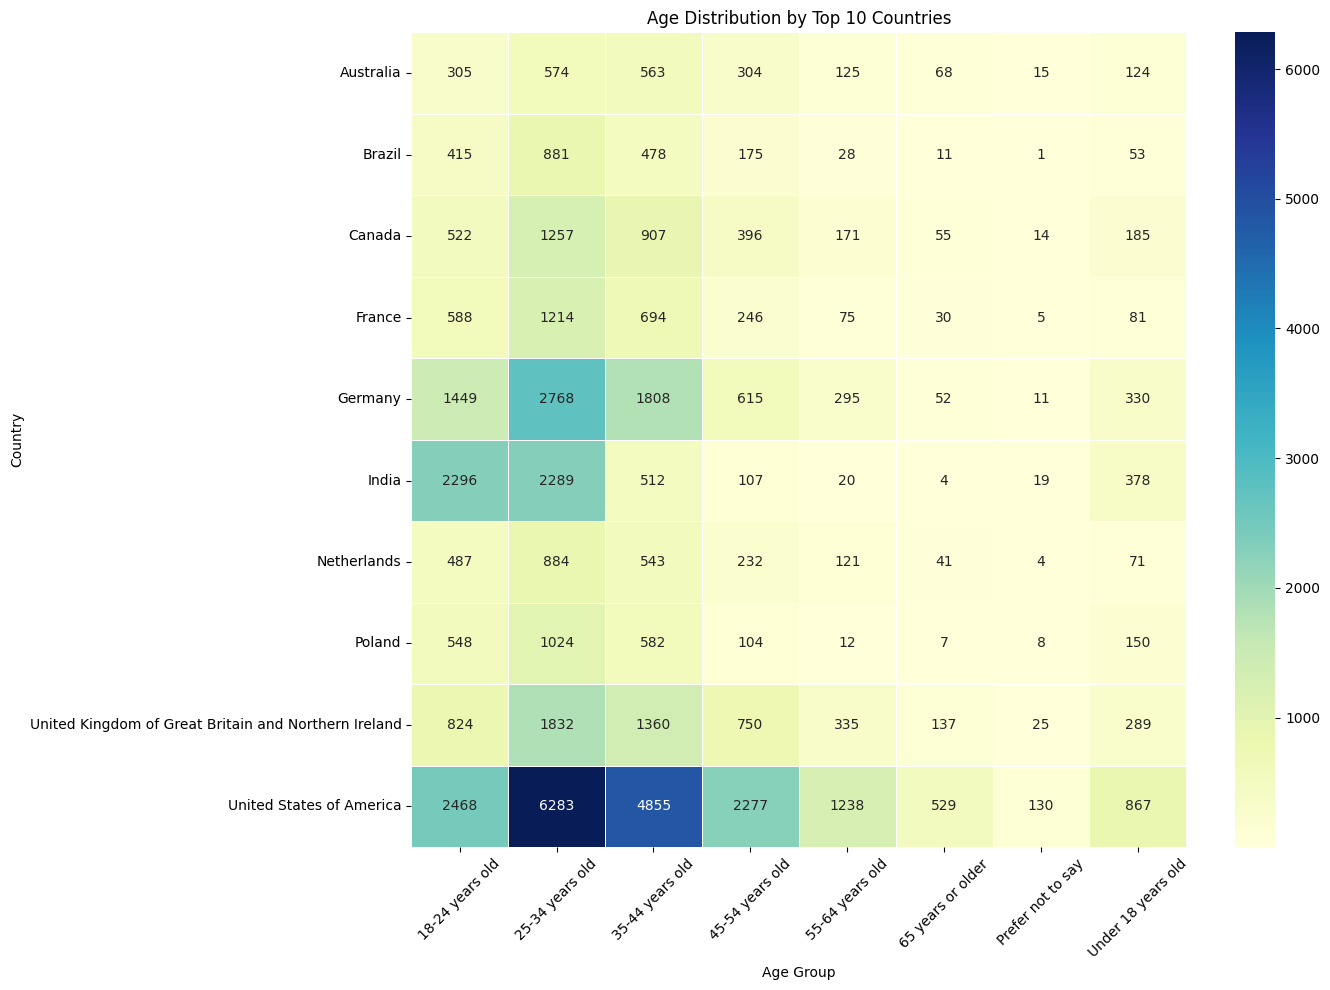

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.heatmap(df_pivot_top_10, cmap='YlGnBu', annot=True, fmt='g', linewidths=0.5)
plt.xlabel('Age Group')
plt.ylabel('Country')
plt.title('Age Distribution by Top 10 Countries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [65]:
df_demo_transformed.groupBy('YearsCodePro').count().show()


+------------+-----+
|YearsCodePro|count|
+------------+-----+
|          31|  187|
|          34|  177|
|          28|  417|
|          27|  490|
|          26|  486|
|          44|   42|
|          12| 2398|
|          22|  845|
|          47|   24|
|        NULL|23048|
|           1| 2596|
|          13| 1690|
|           6| 3637|
|          16| 1278|
|           3| 4378|
|          40|  329|
|          20| 2227|
|          48|   30|
|           5| 4792|
|          19|  649|
+------------+-----+
only showing top 20 rows



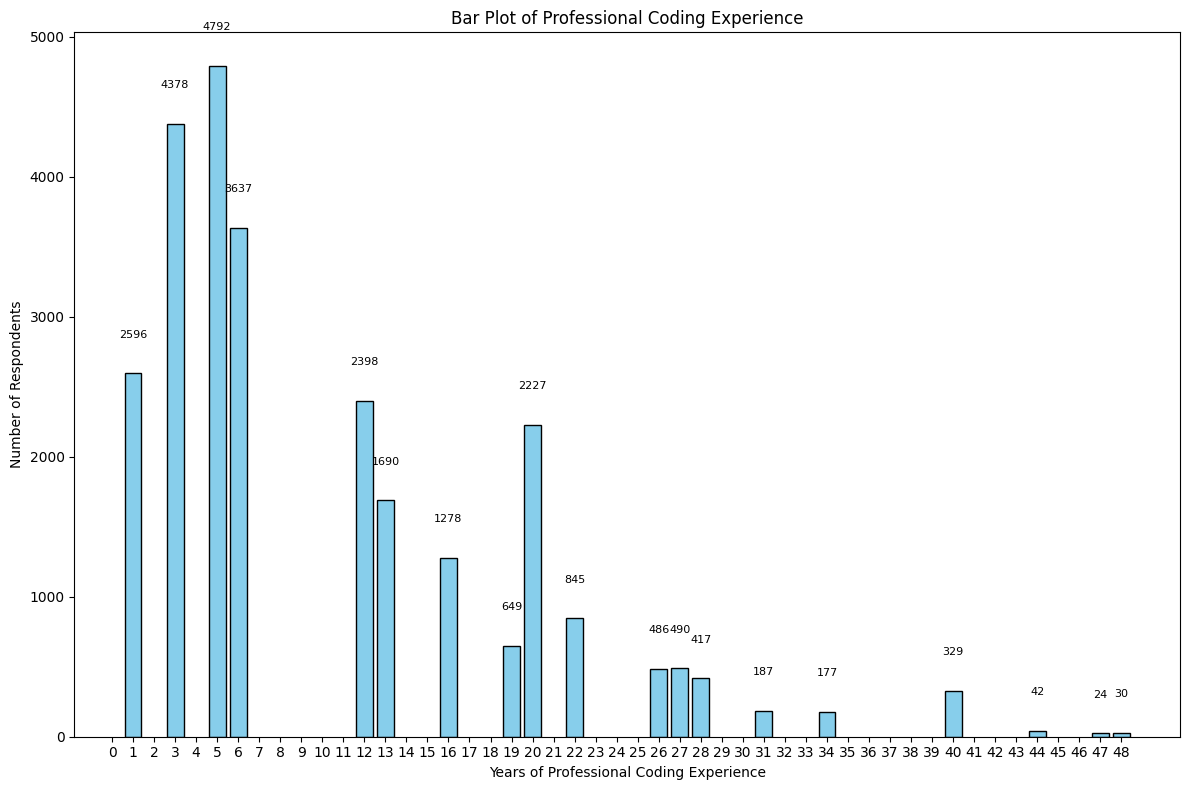

In [72]:
import matplotlib.pyplot as plt

# Data from your DataFrame
years_code_pro_data = {
    'YearsCodePro': [31, 34, 28, 27, 26, 44, 12, 22, 47, None, 1, 13, 6, 16, 3, 40, 20, 48, 5, 19],
    'Count': [187, 177, 417, 490, 486, 42, 2398, 845, 24, 23048, 2596, 1690, 3637, 1278, 4378, 329, 2227, 30, 4792, 649]
}

# Remove NULL values and prepare data for plotting
data = [(years_code_pro, count) for years_code_pro, count in zip(years_code_pro_data['YearsCodePro'], years_code_pro_data['Count']) if years_code_pro is not None]

# Separate years and counts
years, counts = zip(*data)

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.bar(years, counts, color='skyblue', edgecolor='black')

# Add count labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05 * max(counts), int(yval), va='bottom', ha='center', fontsize=8)

plt.xlabel('Years of Professional Coding Experience')
plt.ylabel('Number of Respondents')
plt.title('Bar Plot of Professional Coding Experience')
plt.xticks(range(0, max(years) + 1, 1))  # Adjust x-ticks if needed
plt.tight_layout()
plt.show()


In [73]:
# Calculate the count of respondents by education level
df_education_counts = df_demo_transformed.groupBy('EdLevel').count()
df_education_counts.show()


+--------------------+-----+
|             EdLevel|count|
+--------------------+-----+
|Primary/elementar...| 1905|
|                NULL| 1211|
|Bachelor’s degree...|36706|
|Associate degree ...| 2807|
|Secondary school ...| 8897|
|Professional degr...| 3887|
|Master’s degree (...|20543|
|Some college/univ...|11753|
|      Something else| 1475|
+--------------------+-----+



In [75]:
distinct_ed_levels = df_demo_transformed.select('EdLevel').distinct().collect()
distinct_ed_levels

[Row(EdLevel='Primary/elementary school'),
 Row(EdLevel='Bachelor’s degree (B.A., B.S., B.Eng., etc.)'),
 Row(EdLevel='Associate degree (A.A., A.S., etc.)'),
 Row(EdLevel='Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)'),
 Row(EdLevel='Professional degree (JD, MD, Ph.D, Ed.D, etc.)'),
 Row(EdLevel='Master’s degree (M.A., M.S., M.Eng., MBA, etc.)'),
 Row(EdLevel='Some college/university study without earning a degree'),
 Row(EdLevel='Something else'),
 Row(EdLevel=None)]

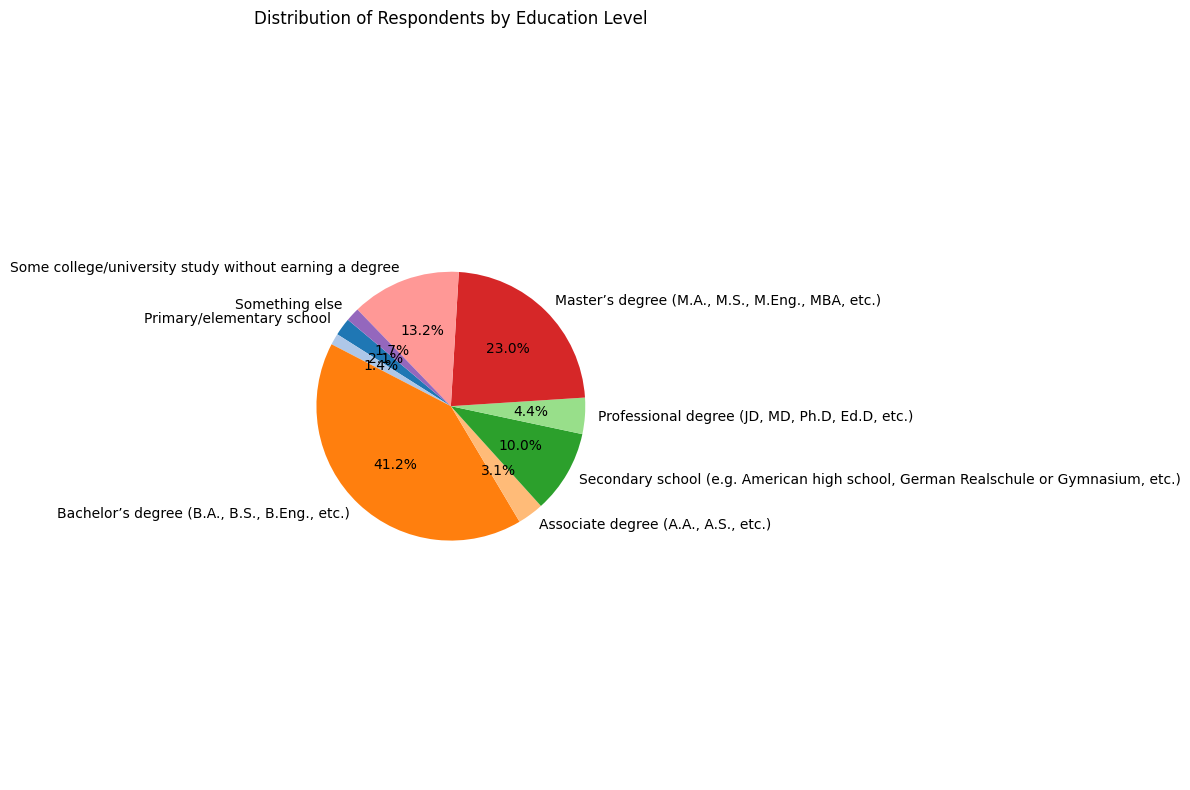

In [77]:
import matplotlib.pyplot as plt
# Convert Spark DataFrame to Pandas DataFrame
df_education_pandas = df_education_counts.toPandas()

# Data from your DataFrame
education_data = df_education_pandas

# Plotting
plt.figure(figsize=(10, 8))
plt.pie(education_data['count'], labels=education_data['EdLevel'], autopct='%1.1f%%', colors=plt.get_cmap('tab20').colors, startangle=140)
plt.title('Distribution of Respondents by Education Level')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()


In [87]:
spark.stop()